In [1]:
import pandas as pd
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
class Classifier(nn.Module):
    def __init__(self, stack):
        super().__init__()
        self.flatten = nn.Flatten()
        self.lin_stack = stack

    def forward(self, x):
        x = self.flatten(x)
        logits = self.lin_stack(x)
        return logits

class NeuralNetwork():
    def __init__(self, loss_fn, epochs, stack, learning_rate, optimizer=optim.Adam, path='./data/normal/'):
        self.loss_fn = loss_fn
        self.epochs = epochs
        self. device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.learning_rate = learning_rate
        self.data_path = path

        #Initialize the model
        self.model = Classifier(stack)
        self.model.to(self.device)

        self.optimizer_class = optimizer
        self.optimizer = optimizer(self.model.parameters(), lr=learning_rate)

        self.X_train, self.Y_train, self.X_val, self.Y_val, self.X_test, self.Y_test = self.convert_to_tensor_dataset()

    
    def convert_to_tensor_dataset(self):

        # Import training and testing data
        train = pd.read_csv(self.data_path + 'train.csv')
        test = pd.read_csv(self.data_path + 'test.csv')

        # Drop the target column from the training data
        X_train = train.drop('Result', axis=1)
        y_train = train['Result']

        # Drop the target column from the testing data
        X_test = test.drop('Result', axis=1)
        y_test = test['Result']


        encoder = OneHotEncoder()
        y_train = encoder.fit_transform(y_train.values.reshape(-1,1)).toarray()

        encoder = OneHotEncoder()
        y_test = encoder.fit_transform(y_test.values.reshape(-1,1)).toarray()

        X_df_train, X_df_val, y_df_train, y_df_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        X_train = torch.tensor(X_df_train.values).float().to(self.device)
        y_train = torch.tensor(y_df_train).float().to(self.device)

        X_val = torch.tensor(X_df_val.values).float().to(self.device)
        y_val = torch.tensor(y_df_val).float().to(self.device)

        X_test = torch.tensor(X_test.values).float().to(self.device)
        y_test = torch.tensor(y_test).float().to(self.device)

        return X_train, y_train, X_val, y_val, X_test, y_test
    
    def train_full(self, verbose=True, graph_data=False):

        epoch_accuracy_train = []
        epoch_accuracy_val = []
        epoch_loss = []
        epoch_val_loss = []

        for t in range(self.epochs):

            # Forward pass
            Y_pred = self.model(self.X_train)
            loss = self.loss_fn(Y_pred, self.Y_train)

            _, predicted_pred = torch.max(Y_pred, dim=1)
            _, predicted_val = torch.max(self.Y_train, dim=1)

            train_accuracy = (predicted_val == predicted_pred).float().mean().item()

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            epoch_loss.append(loss.item())
            epoch_accuracy_train.append(100 * train_accuracy)
            
            with torch.no_grad():
                Y_pred = self.model(self.X_val)
                val_loss = self.loss_fn(Y_pred, self.Y_val)

                _, predicted_pred = torch.max(Y_pred, dim=1)
                _, predicted_val = torch.max(self.Y_val, dim=1)

                val_accuracy = (predicted_pred == predicted_val).float().mean().item()
                epoch_accuracy_val.append(100* val_accuracy)
                epoch_val_loss.append(val_loss.item())

            if t % 50 == 0 and verbose:
                print(f'Epoch {t} | Loss: {loss.item()} | Accuracy: {train_accuracy} | Validation Accuracy: {val_accuracy} | Validation Loss: {val_loss.item()}')

        with torch.no_grad():
            # Get model f1-score
            Y_pred = self.model(self.X_test)
            test_loss = self.loss_fn(Y_pred, self.Y_test).item()

            _, predicted_pred = torch.max(Y_pred, dim=1)
            _, predicted_test = torch.max(self.Y_test, dim=1)

            test_accuracy = (predicted_pred == predicted_test).float().mean().item()
            # test_f1_scr = f1_score(predicted_test, predicted_pred, average=None)
            # test_prec_recall = precision_recall_fscore_support(predicted_test, predicted_pred, average=None, labels=[0, 1, 2], zero_division=0) 

            if verbose:
                print('Testing Data')
                print(f'Accuracy: {test_accuracy}')
                # print(f'F1 Score: {test_f1_scr.mean()}')
                # print(f'Precision: {test_prec_recall[0].mean()}')
                # print(f'Recall: {test_prec_recall[1].mean()}')

                fig,pos = plt.subplots(2,1,figsize=(7,7))
                pos[0].plot(range(self.epochs),epoch_loss, label="Train Loss")
                pos[0].plot(range(self.epochs),epoch_val_loss, label="Validation Loss")
                pos[0].set_xlabel("Epochs")
                pos[0].set_ylabel("Losses")
                pos[0].set_title("Losses")
                pos[0].legend()
                pos[1].plot(range(self.epochs),epoch_accuracy_train,label="Train Accuracy")
                pos[1].plot(range(self.epochs),epoch_accuracy_val,label="Validation Accuracy")
                pos[1].set_xlabel("Epochs")
                pos[1].set_ylabel("Accuracies")
                pos[1].set_title("Train and test accuracies")
                pos[1].legend()
                plt.tight_layout()

            if graph_data:
                return epoch_accuracy_train, epoch_accuracy_val, epoch_loss, epoch_val_loss
            else:
                return test_accuracy, test_loss

    def reset_weights(self, m):
        for layer in m.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def run_kfold_full(self, k_folds=5, f1=False):

        # Create data for kfold
        data = pd.read_csv(self.data_path + 'full.csv')

        X_train = data.drop('Result', axis=1).values

        encoder = OneHotEncoder()
        Y_train = data['Result']
        Y_train = encoder.fit_transform(Y_train.values.reshape(-1,1)).toarray()

        X_train = torch.tensor(X_train).float().to(self.device)
        Y_train = torch.tensor(Y_train).float().to(self.device)

        kfold = KFold(n_splits=k_folds, shuffle=True, random_state=7)

        k_accuracy_val = []
        k_loss_val = []
        k_recall = []
        k_precision = []
        k_f1 = []

        for fold, (train_index, val_index) in enumerate(kfold.split(X_train)):

            self.model.apply(self.reset_weights)
            self.optimizer = self.optimizer_class(self.model.parameters(), lr=self.learning_rate)

            X_train_fold = X_train[train_index]
            Y_train_fold = Y_train[train_index]
            X_val_fold = X_train[val_index]
            Y_val_fold = Y_train[val_index]

            for t in range(self.epochs):

                self.model.train()
                # Forward pass
                Y_pred = self.model(X_train_fold)
                loss = self.loss_fn(Y_pred, Y_train_fold)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            with torch.no_grad():
                Y_pred = self.model(X_val_fold)
                val_loss = self.loss_fn(Y_pred, Y_val_fold)

                _, predicted_pred = torch.max(Y_pred, dim=1)
                _, predicted_val = torch.max(Y_val_fold, dim=1)

                val_accuracy = (predicted_val == predicted_pred).float().mean().item()

                k_precision.append(precision_score(predicted_val, predicted_pred, average='binary'))
                k_recall.append(recall_score(predicted_val, predicted_pred, average='binary'))
                k_f1.append(f1_score(predicted_val, predicted_pred, average='binary'))

            k_accuracy_val.append(val_accuracy)
            k_loss_val.append(val_loss.item())
        
        if f1:
            return k_accuracy_val, k_loss_val, k_f1, k_precision, k_recall
        else:
            return k_accuracy_val, k_loss_val



Activation Function:  <class 'torch.nn.modules.activation.ReLU'>
Activation Function:  <class 'torch.nn.modules.activation.LeakyReLU'>
Activation Function:  <class 'torch.nn.modules.activation.Tanh'>
Activation Function:  <class 'torch.nn.modules.activation.Sigmoid'>
Activation Function:  <class 'torch.nn.modules.activation.Softplus'>


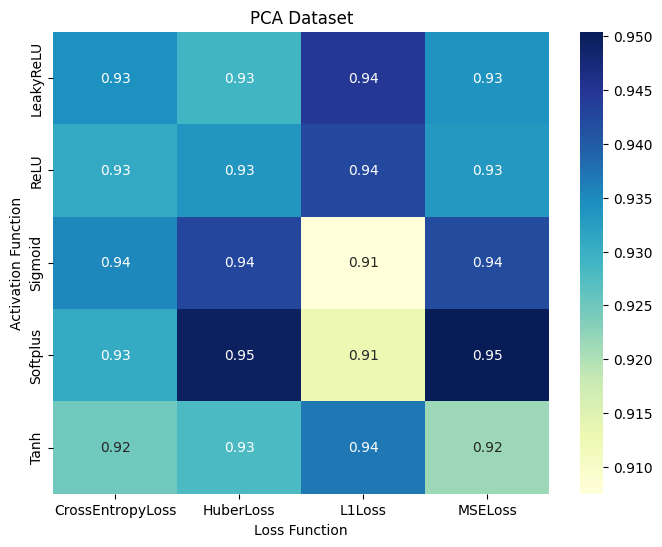

In [31]:
loss_functions = [nn.CrossEntropyLoss, nn.L1Loss, nn.MSELoss, nn.HuberLoss]
activation_functions = [nn.ReLU, nn.LeakyReLU, nn.Tanh, nn.Sigmoid, nn.Softplus]

param1 = []
param2 = []
accuracy = []
loss = []

for i, act in enumerate(activation_functions):
    print("Activation Function: ", act)
    for j, lossf in enumerate(loss_functions):
        stack = nn.Sequential(
            nn.Linear(30, 64),
            act(),
            nn.Linear(64, 32),
            act(),
            nn.Linear(32, 2),
        )
        test_accuracy_arr = []

        model = NeuralNetwork(lossf(), 2000, stack, 0.001, path='../data/pca/')
        test_accuracy, test_loss, = model.run_kfold_full()

        for i in range(len(test_accuracy)):
            param1.append(act.__name__)
            param2.append(lossf.__name__)
            accuracy.append(test_accuracy[i])
            loss.append(test_loss[i])

data = {
    'Activation Function': param1,
    'Loss Function': param2,
    'Accuracy': accuracy,
    'Loss': loss
}

results = pd.DataFrame(data)

pivot_table = pd.pivot_table(results, values='Accuracy', index='Activation Function', columns='Loss Function')

# Plotting the heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', cbar=True)
plt.title('PCA Dataset')
plt.show()

Epoch 0 | Loss: 0.3142503798007965 | Accuracy: 0.5108428597450256 | Validation Accuracy: 0.5261043906211853 | Validation Loss: 0.2819090485572815
Epoch 50 | Loss: 0.14396987855434418 | Accuracy: 0.8859825730323792 | Validation Accuracy: 0.8815261125564575 | Validation Loss: 0.13713262975215912
Epoch 100 | Loss: 0.07600998133420944 | Accuracy: 0.920187771320343 | Validation Accuracy: 0.9257028102874756 | Validation Loss: 0.07161890715360641
Epoch 150 | Loss: 0.07170823961496353 | Accuracy: 0.9224234223365784 | Validation Accuracy: 0.9236947894096375 | Validation Loss: 0.06753388047218323
Epoch 200 | Loss: 0.06814474612474442 | Accuracy: 0.9246590733528137 | Validation Accuracy: 0.9257028102874756 | Validation Loss: 0.06388494372367859
Epoch 250 | Loss: 0.06462281197309494 | Accuracy: 0.9291303157806396 | Validation Accuracy: 0.9297188520431519 | Validation Loss: 0.06025613844394684
Epoch 300 | Loss: 0.061306484043598175 | Accuracy: 0.9327073693275452 | Validation Accuracy: 0.93373495340

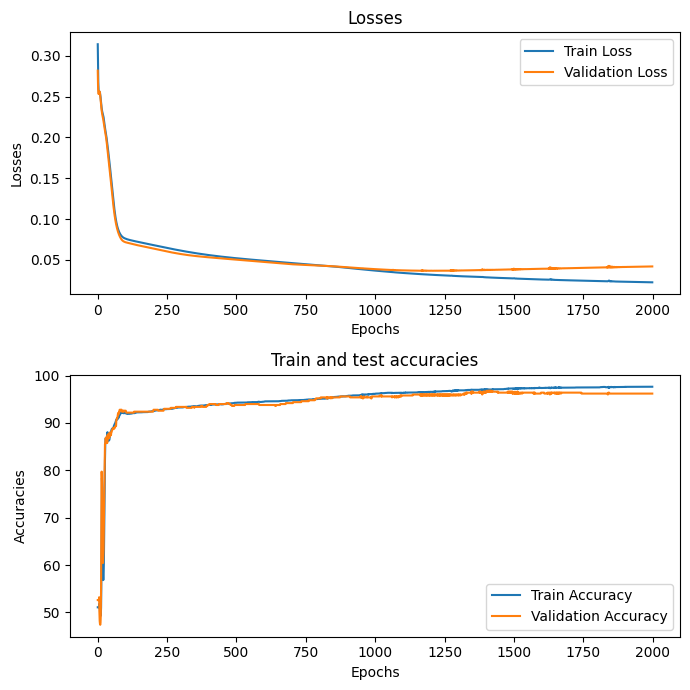

In [4]:
# PCA-reduced data
act_funct = nn.Softplus()

stack = nn.Sequential(
    nn.Linear(30, 64),
    act_funct,
    nn.Linear(64, 32),
    act_funct,
    nn.Linear(32, 2),
)

accuracy = []
loss = []
epochs = 2000

model = NeuralNetwork(nn.MSELoss(),epochs , stack, 0.001, optim.Adam, path='../data/pca/')
accuracies, losses = model.train_full()

print(accuracies)
print(losses)

Epoch 0 | Loss: 1.1711115837097168 | Accuracy: 0.5052537322044373 | Validation Accuracy: 0.5200803279876709 | Validation Loss: 1.041803002357483
Epoch 50 | Loss: 0.15225829184055328 | Accuracy: 0.8696624040603638 | Validation Accuracy: 0.8654618263244629 | Validation Loss: 0.1464974582195282
Epoch 100 | Loss: 0.08420557528734207 | Accuracy: 0.9096803069114685 | Validation Accuracy: 0.9056224822998047 | Validation Loss: 0.07883373647928238
Epoch 150 | Loss: 0.07852139323949814 | Accuracy: 0.9152693748474121 | Validation Accuracy: 0.9076305031776428 | Validation Loss: 0.07478959113359451
Epoch 200 | Loss: 0.07703983783721924 | Accuracy: 0.9159401059150696 | Validation Accuracy: 0.9156626462936401 | Validation Loss: 0.07339136302471161
Epoch 250 | Loss: 0.07603366672992706 | Accuracy: 0.9177286028862 | Validation Accuracy: 0.9156626462936401 | Validation Loss: 0.0724085345864296
Epoch 300 | Loss: 0.07514095306396484 | Accuracy: 0.9186228513717651 | Validation Accuracy: 0.9156626462936401 

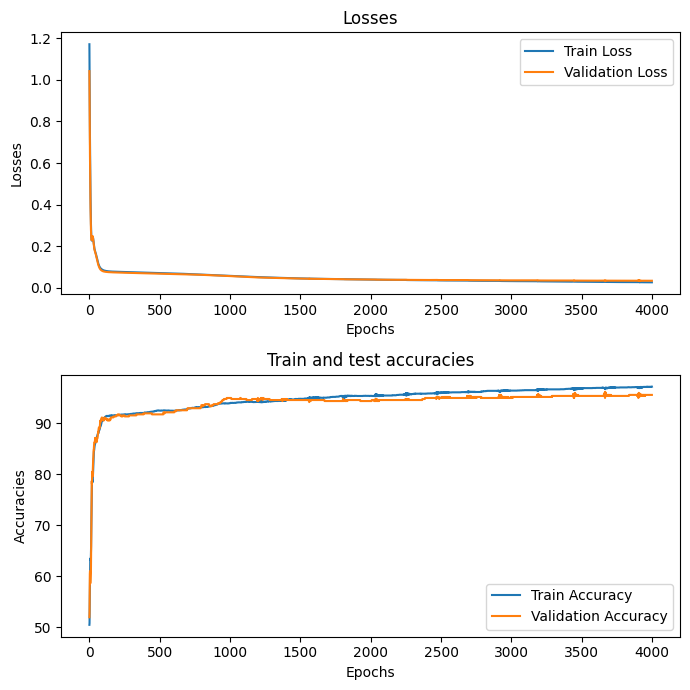

In [5]:
# Normal Data
act_funct = nn.Softplus()

stack = nn.Sequential(
    nn.Linear(30, 64),
    act_funct,
    nn.Linear(64, 32),
    act_funct,
    nn.Linear(32, 2),
)

accuracy = []
loss = []
epochs = 4000

model = NeuralNetwork(nn.MSELoss(),epochs , stack, 0.001, optim.Adam, path='../data/normal/')
accuracies, losses = model.train_full()

print(accuracies)
print(losses)

In [14]:
act_funct = nn.Softplus()

stack = nn.Sequential(
    nn.Linear(30, 64),
    act_funct,
    nn.Linear(64, 32),
    act_funct,
    nn.Linear(32, 2),
)

accuracy = []
loss = []
epochs = 2000

model = NeuralNetwork(nn.MSELoss(),epochs , stack, 0.001, optim.Adam, path='../data/pca/')
accuracies, losses, f1, precision, recall = model.run_kfold_full(f1=True)

print(f"PCA Dataset accuracy: {accuracies}")
print(f"PCA Dataset recall: {recall}")
print(f"PCA Dataset precision: {precision}")
print(f"PCA Dataset f1: {f1}")
print(f"PCA Dataset loss: {losses}")

model = NeuralNetwork(nn.MSELoss(),epochs , stack, 0.001, optim.Adam, path='../data/normal/')
accuracies, losses, f1, precision, recall = model.run_kfold_full(f1=True)

print(f"Normal Dataset accuracy: {accuracies}")
print(f"Normal Dataset recall: {recall}")
print(f"Normal Dataset precision: {precision}")
print(f"Normal Dataset f1: {f1}")
print(f"Normal Dataset loss: {losses}")

PCA Dataset accuracy: [0.9564102292060852, 0.9435897469520569, 0.9547008275985718, 0.9606837630271912, 0.9538066983222961]
PCA Dataset recall: [np.float64(0.9581818181818181), np.float64(0.9520426287744227), np.float64(0.951304347826087), np.float64(0.9699646643109541), np.float64(0.9513888888888888)]
PCA Dataset precision: [np.float64(0.9495495495495495), np.float64(0.9321739130434783), np.float64(0.9562937062937062), np.float64(0.9498269896193772), np.float64(0.9547038327526133)]
PCA Dataset f1: [np.float64(0.9538461538461539), np.float64(0.9420035149384886), np.float64(0.953792502179599), np.float64(0.9597902097902098), np.float64(0.9530434782608695)]
PCA Dataset loss: [0.03970437869429588, 0.04836544394493103, 0.04322008043527603, 0.03937892988324165, 0.04349813982844353]
Normal Dataset accuracy: [0.9495726227760315, 0.9307692050933838, 0.9529914259910583, 0.9529914259910583, 0.9418306350708008]
Normal Dataset recall: [np.float64(0.96), np.float64(0.9538188277087034), np.float64(0.